<a href="https://colab.research.google.com/github/Mohadese-ghayoomi/Assignments-of-DL/blob/main/Assignment_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing the required Libraries**

In [90]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

# **Loading the Dataset**

In [91]:
os.getcwd()

'/content/drive/My Drive/Colab Notebooks'

In [92]:
os.chdir('/content/drive/My Drive/Colab Notebooks')

In [93]:
from google.colab import drive


In [94]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z,".", "?", "!", ",")
  #w = re.sub(r"[^a-zA-Z?.!,¿ا ب پ ت س ج چ ح خ د ذ ر ز ژ س ش ص ض ط ظ ع غ ف ق ک گ ل م ن و ه ی]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [96]:
en_sentence = u"Get out!"
pes_sentence = u"برو بیرون!"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(pes_sentence))
print(preprocess_sentence(pes_sentence).encode('utf-8'))

<start> get out ! <end>
<start> برو بیرون ! <end>
b'<start> \xd8\xa8\xd8\xb1\xd9\x88 \xd8\xa8\xdb\x8c\xd8\xb1\xd9\x88\xd9\x86 ! <end>'


In [97]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, persian]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:-1] ]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [98]:
path_to_file = "pes.txt"
en, pes = create_dataset("pes.txt", 50)
print(en)
print(pes)

('<start> who ? <end>', '<start> go on . <end>', '<start> smile . <end>', '<start> attack ! <end>', '<start> got it ! <end>', '<start> i know . <end>', '<start> listen . <end>', '<start> really ? <end>', '<start> really ? <end>', '<start> why me ? <end>', '<start> be cool . <end>', '<start> be cool . <end>', '<start> be cool . <end>', '<start> come in . <end>', '<start> come on ! <end>', '<start> get out ! <end>', '<start> get out ! <end>', '<start> go away ! <end>', '<start> go away ! <end>', '<start> help me ! <end>', '<start> help me ! <end>', '<start> hold it ! <end>', '<start> see you . <end>', '<start> see you . <end>', '<start> shut up ! <end>', '<start> so long . <end>', '<start> take it . <end>', '<start> tell me . <end>', '<start> welcome . <end>', '<start> get away ! <end>', '<start> grab him . <end>', '<start> hurry up . <end>', '<start> keep out ! <end>', '<start> speak up ! <end>', '<start> terrific ! <end>', '<start> we agree . <end>', '<start> what for ? <end>', '<start

In [ ]:
#path_to_file = "deu.txt"
#en, deu = create_dataset("deu.txt", None)
#print(en[-1])
#print(deu[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa; but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> ohne zweifel findet sich auf dieser welt zu jedem mann genau die richtige ehefrau und umgekehrt; wenn man jedoch in betracht zieht , dass ein mensch nur gelegenheit hat , mit ein paar hundert anderen bekannt zu sein , von denen ihm nur ein dutzend oder weniger nahesteht , darunter hochstens ein oder zwei freunde , dann erahnt man eingedenk der millionen einwohner dieser welt leicht , dass seit erschaffung ebenderselben wohl noc

source :https://www.tensorflow.org/guide/keras/masking_and_padding

In [99]:
#This class allows to vectorize a text corpus, by turning each text into either a sequence of integers
#(each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
#Trains the model for a fixed number of epochs (iterations on a dataset)
  lang_tokenizer.fit_on_texts(lang)
#Transforms each text in texts to a sequence of integers.
#Each item in texts can also be a list, in which case we assume each item of that list to be a token.
  tensor = lang_tokenizer.texts_to_sequences(lang)
#Pads sequences to the same length
#Since the input data for a deep learning model must be a single tensor
#(of shape e.g. (batch_size, 6, vocab_size) in this case), samples that are shorter than the longest item
#need to be padded with some placeholder value (alternatively, one might also truncate long samples before padding short samples).
#Keras provides a utility function to truncate and pad Python lists to a common length
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post') #pad after each sequence

  return tensor, lang_tokenizer

In [100]:
#load the dataset, tokenize it and return output as tensors.
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

source :https://www.tensorflow.org/guide/keras/masking_and_padding

Masking
Now that all samples have a uniform length, the model must be informed that some part of the data is actually padding and should be ignored. That mechanism is masking.

There are three ways to introduce input masks in Keras models:

*   Add a keras.layers.Masking layer.
*   Configure a keras.layers.Embedding layer with mask_zero=True.
*   pass a mask argument manually when calling layers that support this argument (e.g. RNN layers).



#**Limitation the size of the dataset to experiment faster**

In [101]:
# Try experimenting with the size of that dataset
#num_examples of persian words = 2275
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
# encoder output of shape (batch_size, max_length, hidden_size) 
# encoder hidden state of shape (batch_size, hidden_size)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [102]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

1820 1820 455 455


In [103]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [104]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[2])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[2])

Input Language; index to word mapping
1 ----> <start>
28 ----> چه
528 ----> موقع
8 ----> می
140 ----> توانم
361 ----> شنا
235 ----> کنم؟
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
59 ----> when
49 ----> can
5 ----> i
636 ----> swim
60 ----> here
10 ----> ?
2 ----> <end>


In [ ]:
#print ("Input Language; index to word mapping")
#convert(inp_lang, input_tensor_train[2])
#print ()
#print ("Target Language; index to word mapping")
#convert(targ_lang, target_tensor_train[2])

Input Language; index to word mapping
1 ----> <start>
12 ----> du
50 ----> bist
759 ----> verliebt
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
48 ----> you're
27 ----> in
98 ----> love
3 ----> .
2 ----> <end>


# **Create a tf.data dataset**

In [105]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)

<BatchDataset shapes: ((64, 33), (64, 37)), types: (tf.int32, tf.int32)>


In [106]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 33]), TensorShape([64, 37]))

# **Encoder class**

In [107]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [108]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 33, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


# **Attention Vector**

In [84]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [85]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 33, 1)


In [86]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [87]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2571)


# **optimizer and the loss function**

In [88]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [89]:
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/CheckPoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                encoder=encoder,
                                 decoder=decoder)

In [ ]:
#checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/CheckPointsDeutsch'
#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
#checkpoint = tf.train.Checkpoint(optimizer=optimizer,
#                                 encoder=encoder,
#                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.7574
Epoch 1 Loss 1.4428
Time taken for 1 epoch 487.21891617774963 sec

Epoch 2 Batch 0 Loss 1.1973
Epoch 2 Loss 1.2059
Time taken for 1 epoch 438.14834856987 sec

Epoch 3 Batch 0 Loss 1.2154
Epoch 3 Loss 1.1342
Time taken for 1 epoch 429.5998623371124 sec

Epoch 4 Batch 0 Loss 0.9652
Epoch 4 Loss 1.0776
Time taken for 1 epoch 463.9787516593933 sec

Epoch 5 Batch 0 Loss 1.0603
Epoch 5 Loss 1.0265
Time taken for 1 epoch 459.9793314933777 sec

Epoch 6 Batch 0 Loss 0.9906
Epoch 6 Loss 0.9783
Time taken for 1 epoch 463.2251205444336 sec

Epoch 7 Batch 0 Loss 0.9278
Epoch 7 Loss 0.9312
Time taken for 1 epoch 463.37100625038147 sec

Epoch 8 Batch 0 Loss 0.9209
Epoch 8 Loss 0.8878
Time taken for 1 epoch 462.47581672668457 sec

Epoch 9 Batch 0 Loss 0.7947
Epoch 9 Loss 0.8468
Time taken for 1 epoch 461.00004482269287 sec

Epoch 10 Batch 0 Loss 0.8316
Epoch 10 Loss 0.8017
Time taken for 1 epoch 459.3907678127289 sec

Epoch 11 Batch 0 Loss 0.7798
Epoch 11 Loss 0.7570
Time t

# **Evaluation**

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

# **testing**

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# **Persian and English**

Input: <start> هوا خیلی تاریک بود . <end>
Predicted translation: it was so dark . <end> 


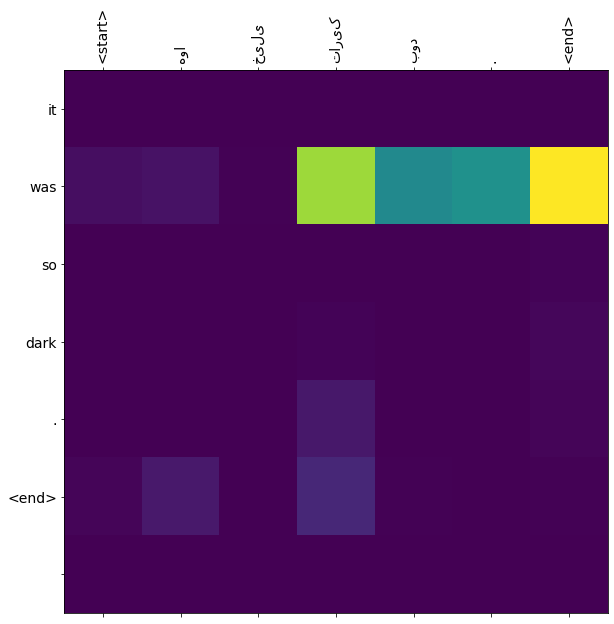

In [ ]:
translate(u' هوا خیلی تاریک بود.')

Input: <start> او به من گفت تا پنج دقیقه دیگر می رسد <end>
Predicted translation: she is wrong ? <end> 


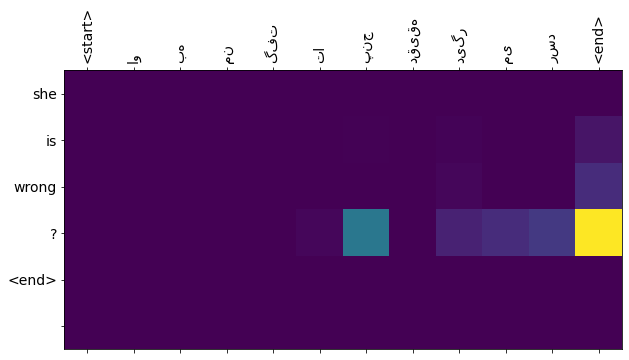

In [ ]:
translate(u'او به من گفت تا پنج دقیقه دیگر می رسد ')

Input: <start> یک دقیقه صبر کنید لطفا <end>
Predicted translation: see the way . <end> 


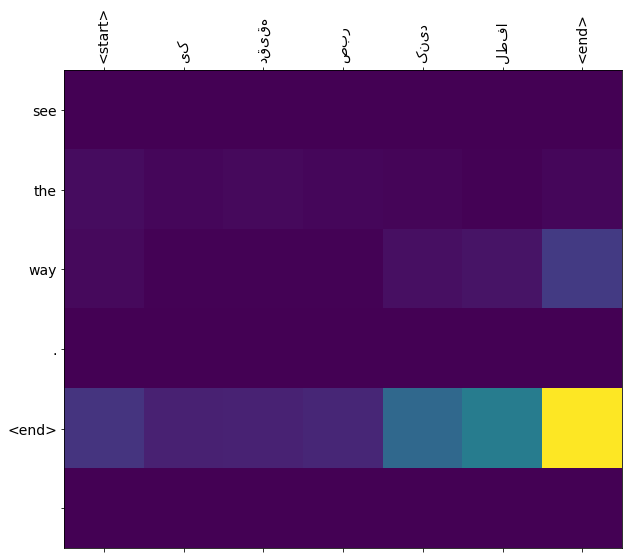

In [ ]:
translate(u'یک دقیقه صبر کنید لطفا')

Input: <start> ادامه بده <end>
Predicted translation: every rose has its thorns . <end> 


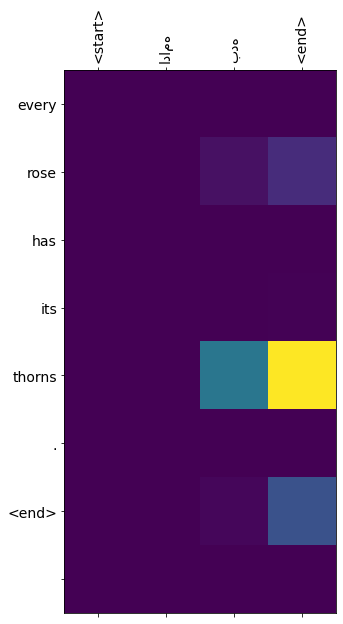

In [ ]:
translate(u' ادامه بده')

Input: <start> به من کمک کن . <end>
Predicted translation: help me ! <end> 


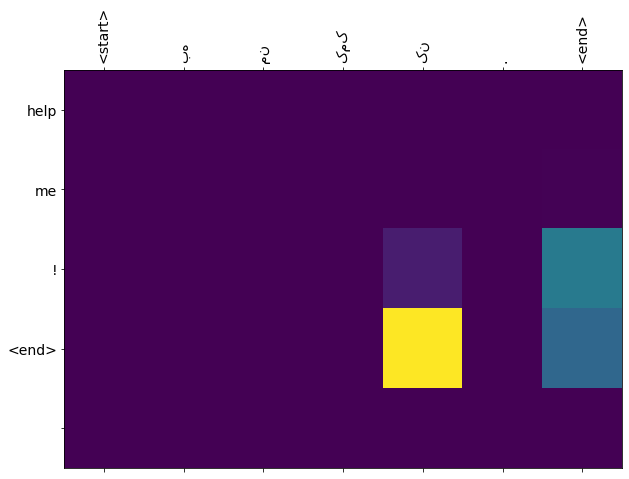

In [ ]:
translate(u'به من کمک کن.')

Input: <start> حرفت را بزن ! <end>
Predicted translation: speak up ! <end> 


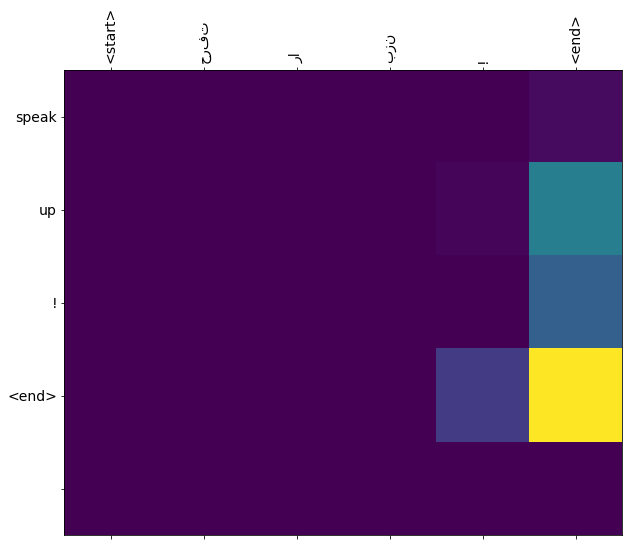

In [ ]:
translate(u'حرفت را بزن!')

# **Luong Attention**

In [ ]:
#Luong-style attention uses the current decoder output to compute the alignment vector
#Luong’s multiplicative attention 
#take the dot product of a matrix (W) and the encoder’s output. What layer can do a dot product----> Dense layer
class LuongAttention(tf.keras.layers.Layer):
  def __init__(self,units, max_len_inp):
    super(LuongAttention,self).__init__()
    self.W = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(max_length_inp)
  
  def call(self, query, values):
    query_with_time_axis = tf.expand_dims(query, 1)

    score = tf.matmul(self.W(query_with_time_axis), values, transpose_b=True)   
    score = tf.transpose(score, [0, 2, 1])
 
    attention_weights = tf.nn.softmax(score,axis = 1)
 
    context = attention_weights*values
  
    context = tf.reduce_sum(context, axis=1)
  
    return context, attention_weights

In [ ]:
attention_layer = LuongAttention(1024,max_length_inp)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 33, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.max_input_length = max_length_inp
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = LuongAttention(self.dec_units, self.max_input_length)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2571)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/luong'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
EPOCHS=50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9200
Epoch 1 Loss 1.4629
Time taken for 1 epoch 247.33612489700317 sec

Epoch 2 Batch 0 Loss 1.3057
Epoch 2 Loss 1.2517
Time taken for 1 epoch 203.74336314201355 sec

Epoch 3 Batch 0 Loss 1.1780
Epoch 3 Loss 1.1675
Time taken for 1 epoch 200.39355373382568 sec

Epoch 4 Batch 0 Loss 1.1646
Epoch 4 Loss 1.0982
Time taken for 1 epoch 199.7145800590515 sec

Epoch 5 Batch 0 Loss 1.1294
Epoch 5 Loss 1.0394
Time taken for 1 epoch 200.97117924690247 sec

Epoch 6 Batch 0 Loss 0.9599
Epoch 6 Loss 0.9915
Time taken for 1 epoch 202.97289848327637 sec

Epoch 7 Batch 0 Loss 0.9594
Epoch 7 Loss 0.9499
Time taken for 1 epoch 204.8530809879303 sec

Epoch 8 Batch 0 Loss 0.8769
Epoch 8 Loss 0.9098
Time taken for 1 epoch 200.7117154598236 sec

Epoch 9 Batch 0 Loss 0.8777
Epoch 9 Loss 0.8751
Time taken for 1 epoch 196.81235527992249 sec

Epoch 10 Batch 0 Loss 0.7646
Epoch 10 Loss 0.8413
Time taken for 1 epoch 197.1666603088379 sec

Epoch 11 Batch 0 Loss 0.7635
Epoch 11 Loss 0.8048
Ti

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [ ]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis',clim=[0,1])

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> من اینجا تنها هستم <end>
Predicted translation: who's that talking to your favorite dessert ? <end> 


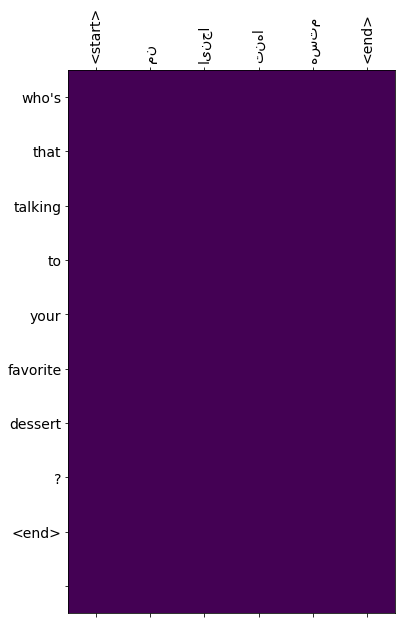

In [ ]:
translate(u'من اینجا تنها هستم')

Input: <start> هوا خیلی تاریک بود . <end>
Predicted translation: the doctors examined the baby . <end> 


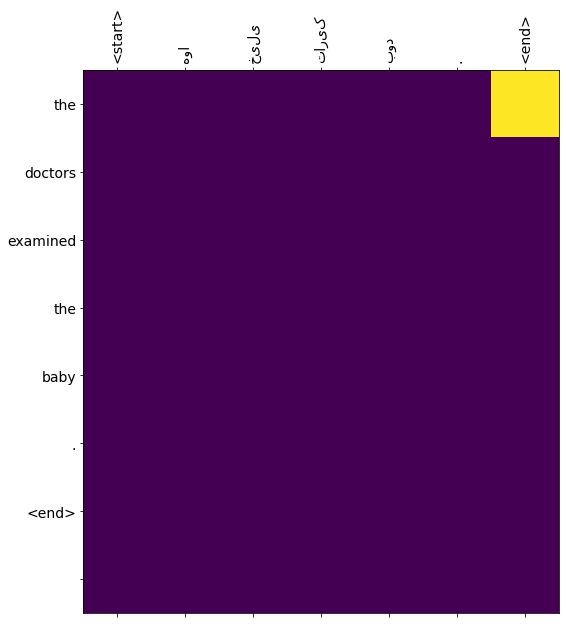

In [ ]:
translate(u' هوا خیلی تاریک بود.')

Input: <start> او به من گفت تا پنج دقیقه دیگر می رسد <end>
Predicted translation: insure it will come again . <end> 


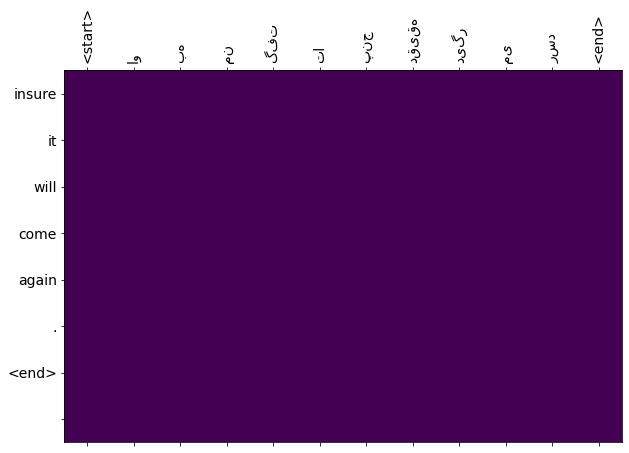

In [ ]:
translate(u'او به من گفت تا پنج دقیقه دیگر می رسد ')

Input: <start> یک دقیقه صبر کنید لطفا <end>
Predicted translation: what are you doing . <end> 


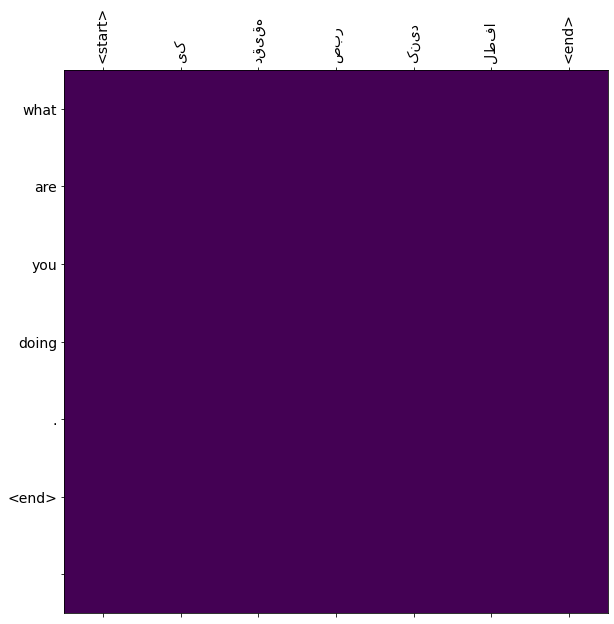

In [ ]:
translate(u'یک دقیقه صبر کنید لطفا')

Input: <start> ادامه بده <end>
Predicted translation: ignorance and heat . <end> 


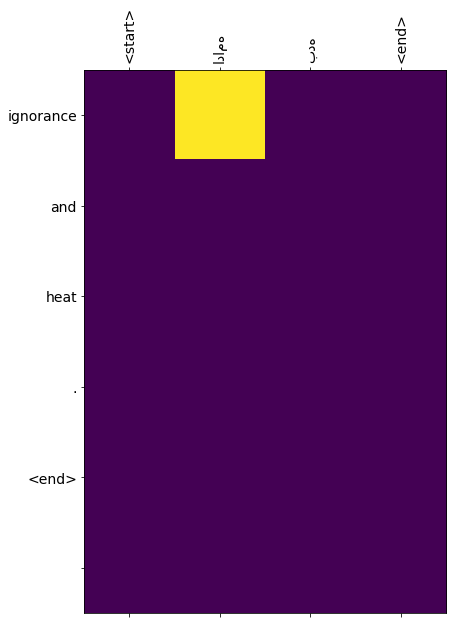

In [ ]:
translate(u' ادامه بده')

Input: <start> به من کمک کن . <end>
Predicted translation: help me ! <end> 


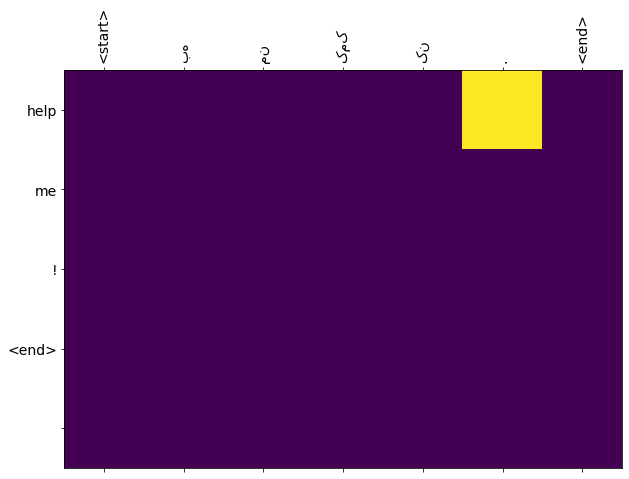

In [ ]:
translate(u'به من کمک کن.')

Input: <start> حرفت را بزن ! <end>
Predicted translation: speak up ! <end> 


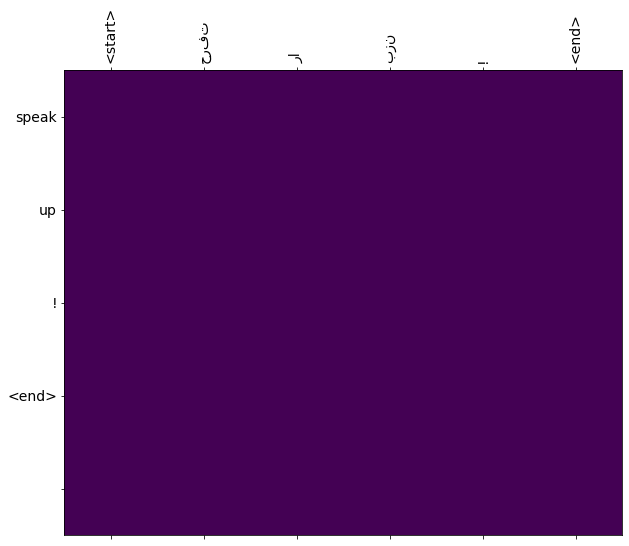

In [ ]:
translate(u'حرفت را بزن!')

# **DotProduct**

In [109]:
class DotProduct(tf.keras.layers.Layer):
  def __init__(self,units):
    super(DotProduct,self).__init__()
  
  def call(self, query, values):

    query_with_time_axis = tf.expand_dims(query, 1)
    
    score  = tf.expand_dims((tf.reduce_sum( tf.multiply(values,query_with_time_axis), 2)),2)

    attention_weights  = tf.nn.softmax(score,axis = 1)
    
    context_vector  = attention_weights*values
    context_vector  = tf.reduce_sum(context_vector , axis=1)
    
    return context_vector, attention_weights

In [110]:
attention_layer = DotProduct(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 33, 1)


In [111]:

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = DotProduct(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [113]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 2571)


In [114]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [115]:
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/dotproduct'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [117]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [118]:
EPOCHS = 50

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9201
Epoch 1 Loss 1.4248
Time taken for 1 epoch 246.7114613056183 sec

Epoch 2 Batch 0 Loss 1.1556
Epoch 2 Loss 1.2136
Time taken for 1 epoch 199.30653619766235 sec

Epoch 3 Batch 0 Loss 1.1793
Epoch 3 Loss 1.1386
Time taken for 1 epoch 204.5761365890503 sec

Epoch 4 Batch 0 Loss 0.9693
Epoch 4 Loss 1.0786
Time taken for 1 epoch 199.75120639801025 sec

Epoch 5 Batch 0 Loss 1.0685
Epoch 5 Loss 1.0266
Time taken for 1 epoch 205.79393815994263 sec

Epoch 6 Batch 0 Loss 1.0777
Epoch 6 Loss 0.9788
Time taken for 1 epoch 202.67754483222961 sec

Epoch 7 Batch 0 Loss 0.9433
Epoch 7 Loss 0.9288
Time taken for 1 epoch 199.92518424987793 sec

Epoch 8 Batch 0 Loss 0.8776
Epoch 8 Loss 0.8799
Time taken for 1 epoch 199.5582399368286 sec

Epoch 9 Batch 0 Loss 0.7522
Epoch 9 Loss 0.8308
Time taken for 1 epoch 201.0636076927185 sec

Epoch 10 Batch 0 Loss 0.8510
Epoch 10 Loss 0.7893
Time taken for 1 epoch 200.63314056396484 sec

Epoch 11 Batch 0 Loss 0.7813
Epoch 11 Loss 0.7449
Ti

In [119]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [120]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis',clim=[0,1])

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [121]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [122]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> من اینجا تنها هستم <end>
Predicted translation: what's your favorite dessert ? <end> 


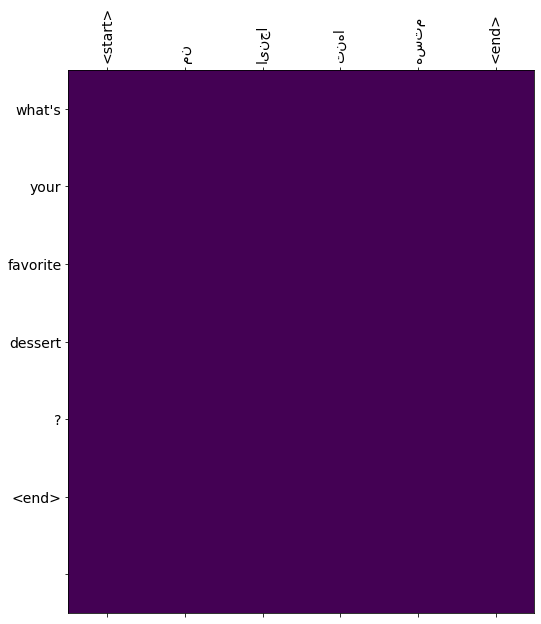

In [53]:
translate(u'من اینجا تنها هستم')

Input: <start> هوا خیلی تاریک بود . <end>
Predicted translation: it was so dark . <end> 


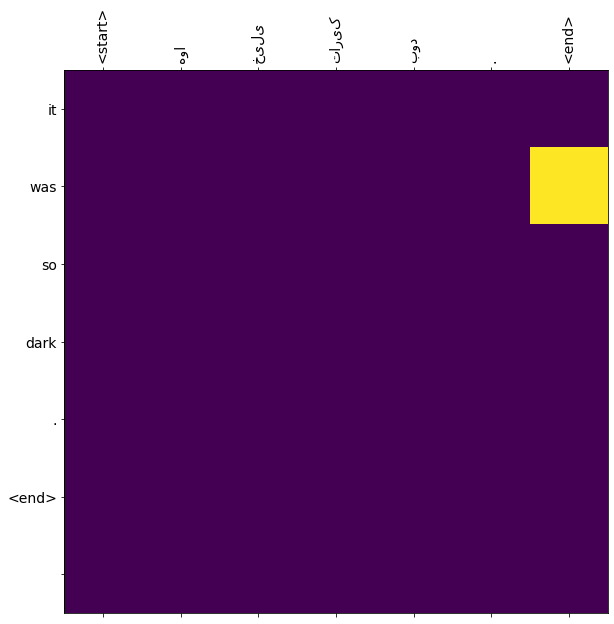

In [54]:
translate(u' هوا خیلی تاریک بود.')

Input: <start> او به من گفت تا پنج دقیقه دیگر می رسد <end>
Predicted translation: he did he did he did he did he did he did he did he did he did he did he did he did he did he did he did he did he did he did he 


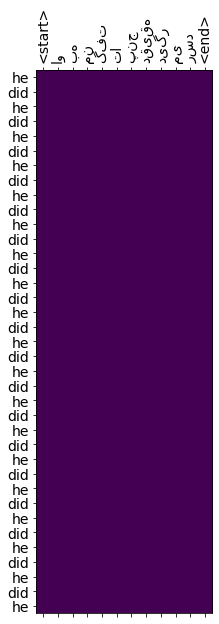

In [63]:
translate(u'او به من گفت تا پنج دقیقه دیگر می رسد ')

Input: <start> یک دقیقه صبر کنید لطفا <end>
Predicted translation: hasn't a good idea ? <end> 


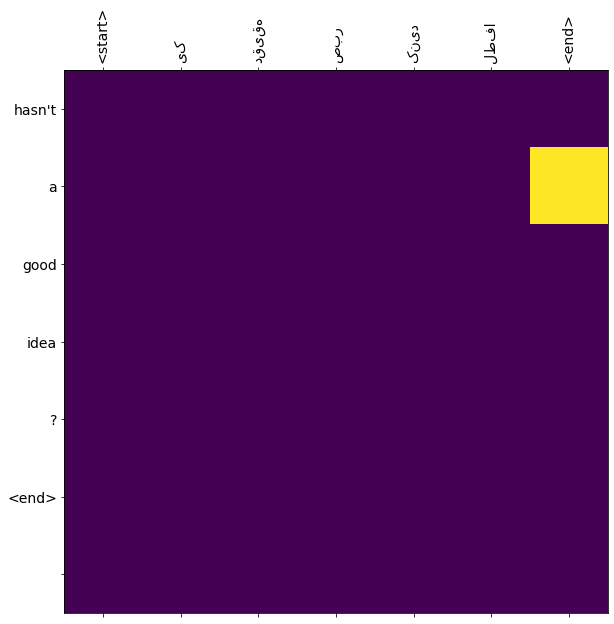

In [58]:
translate(u'یک دقیقه صبر کنید لطفا')

Input: <start> ادامه بده <end>
Predicted translation: go on ! <end> 


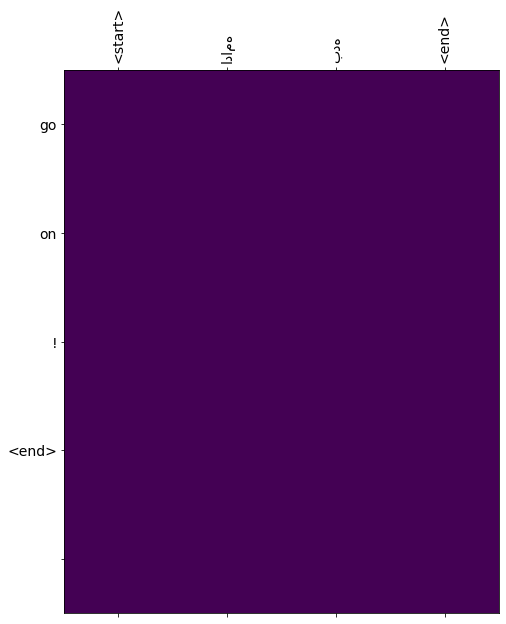

In [59]:
translate(u' ادامه بده')

Input: <start> به من کمک کن . <end>
Predicted translation: let me . <end> 


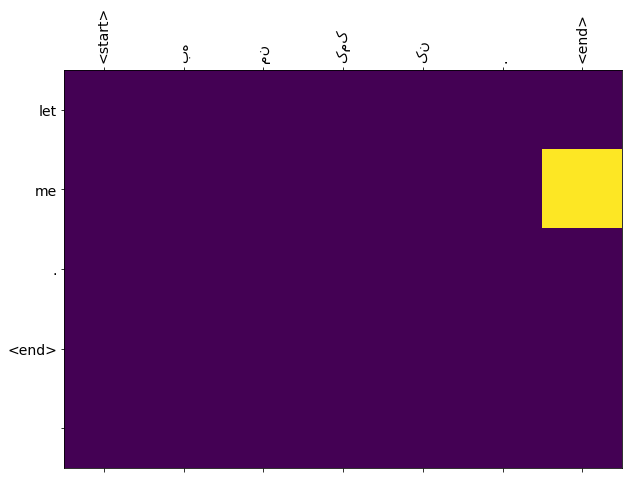

In [60]:
translate(u'به من کمک کن.')

Input: <start> حرفت را بزن ! <end>
Predicted translation: speak up ! <end> 


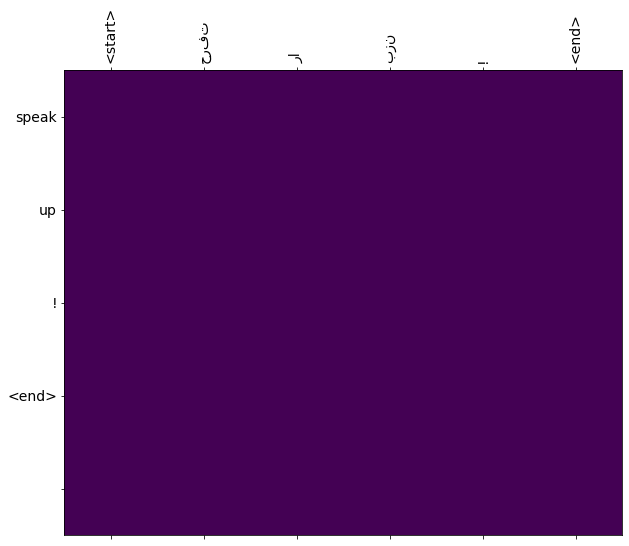

In [61]:
translate(u'حرفت را بزن!')

Do you think that the model attends to the correct tokens in the input language (if you understand both languages)?

For few of them

Do you see qualitative differences in the attention weights between different attention mechanisms?

Dot product transalted most of the sentences correct.


Questions-

Which parts of the sentence are used as a token? Each character, each word, or are some words split up? Answer - - Each word

Do the same tokens in different language have the same ID? e.g. Would the same token index map to the German word die and to the English word die? Answer - No

What is the relation between the encoder output and the encoder hidden state which is used to initialize the decoder hidden state (for the architecture used in the tutorial)? Hidden states along with encoder output are used to calculate scores

Is the decoder attending to all previous positions, including the previous decoder predictions? Yep

Does the Encoder output change in different decoding steps? No

Does the context vector change in different decoding steps? yes based on query

The decoder uses teacher forcing. Does this mean the time steps can be computed in parallel? Answer - Can be, but predcition word depends on the previous word so might not be a good way

Why is a mask applied to the loss function? Answer - because its padded sequence and we don't want loss over padded sequence